# Title: Evaluating the Use of Rule-Based CIELAB Analysis in Undertone Skin Detection


### Objective

The objective of this experiment is to evaluate the effectiveness of a **rule-based approach using CIELAB color space** in detecting **skin undertones** from facial images. Specifically, we aim to determine whether CIELAB values—derived from dominant skin colors extracted via HSV-based masking—are sufficient to classify undertones (cool, warm, neutral) through predefined thresholds.

This experiment serves as a preliminary investigation that supports the need for more robust solutions like our proposed CNN-based system for undertone detection in our thesis work.

---

### Method

We applied a **rule-based classification system** using the a\* and b\* components of the CIELAB color space, which are known to represent chromaticity (red-green and yellow-blue axes, respectively). These values were extracted from dominant RGB skin tones using **OpenCV HSV masking** and the **ColorThief** library.

The classification rules were based on prior studies (e.g., Kaur et al., 2018; Mima et al., 2025) and defined as follows:
- `a* > 15 and b* < 20` → **Cool**
- `b* > 20 and a* < 15` → **Warm**
- `10 ≤ a* ≤ 20 and 15 ≤ b* ≤ 25` → **Neutral**
- All other values → **Unclassified**

Performance was evaluated by comparing predicted undertones to manually labeled ground truth data.

### Imports and Setup

In [367]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from colorthief import ColorThief
from skimage import color
from sklearn.metrics import (
    confusion_matrix,
    precision_recall_fscore_support,
    accuracy_score
)

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

### Load Labels
Ground-truth undertone labels are pre-labeled in a CSV file.

In [368]:
# Load and normalize labels
labels_df = pd.read_csv("undertone_labels.csv")
labels_df["ground_truth_undertone"] = labels_df["ground_truth_undertone"].str.strip().str.lower()

### Sample Image: HSV Skin Masking

To illustrate how the existing skin tone system isolates skin color, we show below the result of applying OpenCV’s HSV mask to one of our sample images (`img1.jpg`).

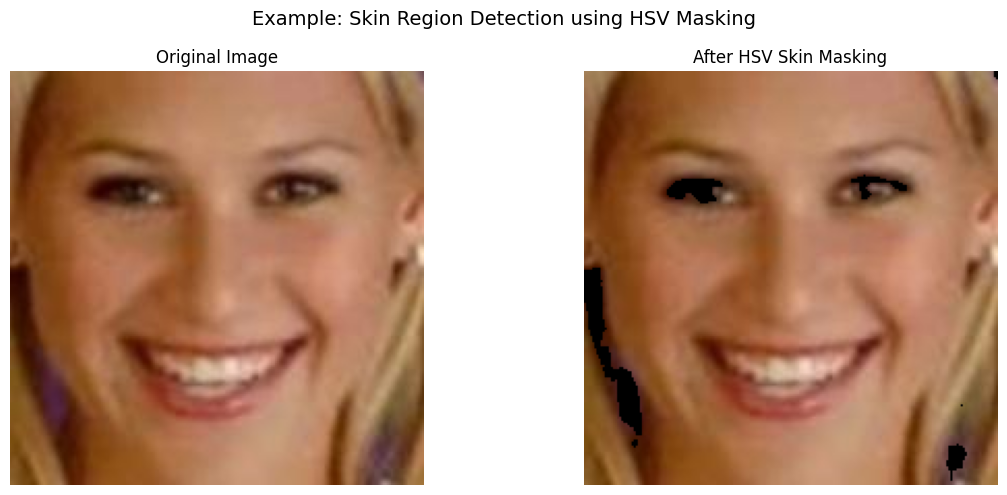

In [369]:
import cv2
import matplotlib.pyplot as plt

# Load sample image
img_path = "images/img188.jpg"  # make sure this path is correct
image = cv2.imread(img_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Apply HSV skin mask
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
lower_skin = (0, 20, 70)
upper_skin = (20, 255, 255)
mask = cv2.inRange(hsv, lower_skin, upper_skin)
masked = cv2.bitwise_and(image_rgb, image_rgb, mask=mask)

# Plot original vs masked
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(masked)
plt.title("After HSV Skin Masking")
plt.axis('off')

plt.suptitle("Example: Skin Region Detection using HSV Masking", fontsize=14)
plt.tight_layout()
plt.show()

### Image Processing and Rule-Based Undertone Prediction
This section simulates a basic tone-detection system by using OpenCV’s HSV skin mask + ColorThief dominant color.
We then classify undertone using:

- `a* > 15 and b* < 20` → **Cool**
- `b* > 20 and a* < 15` → **Warm**
- `10 ≤ a* ≤ 20 and 15 ≤ b* ≤ 25` → **Neutral**

In [370]:
actuals = []
predictions = []
lab_points = []

for index, row in labels_df.iterrows():
    img_name = row["image_name"]
    true_label = row["ground_truth_undertone"]
    img_path = os.path.join("images", img_name)

    image = cv2.imread(img_path)
    if image is None:
        continue

    # Skin segmentation using HSV
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_skin = (0, 20, 70)
    upper_skin = (20, 255, 255)
    mask = cv2.inRange(image_hsv, lower_skin, upper_skin)
    skin = cv2.bitwise_and(image, image, mask=mask)

    # Save temporary image
    temp_path = "temp.jpg"
    cv2.imwrite(temp_path, skin)

    try:
        color_thief = ColorThief(temp_path)
        dominant_rgb = color_thief.get_color(quality=1)
    except:
        continue

    # Convert to CIELAB
    rgb_array = np.array(dominant_rgb) / 255.0
    lab = color.rgb2lab(rgb_array.reshape((1, 1, 3)))
    _, a, b = lab[0, 0]

    # Rule-based logic
    if a > 15 and b < 20:
        pred = "cool"
    elif b > 20 and a < 15:
        pred = "warm"
    elif 10 <= a <= 20 and 15 <= b <= 25:
        pred = "neutral"
    else:
        pred = "unclassified"



    actuals.append(true_label)
    predictions.append(pred)
    lab_points.append((a, b, true_label, pred))


### Class-Specific Confusion Matrices

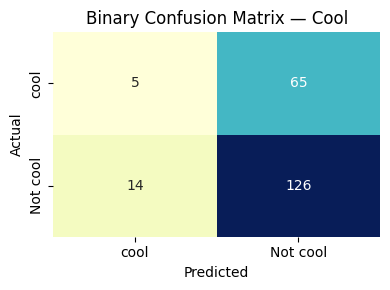

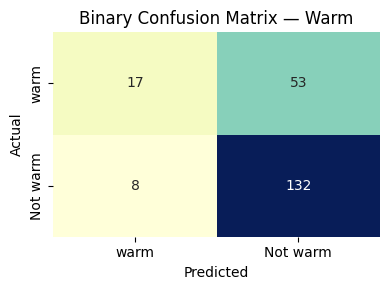

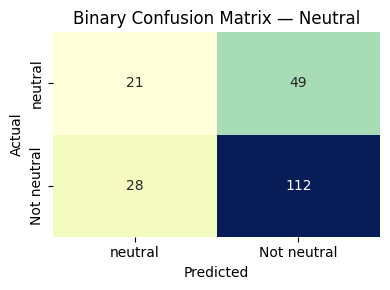

In [371]:
# Normalize predictions
actuals = [a.strip().lower() for a in actuals]
predictions = [p.strip().lower() for p in predictions]

labels = ["cool", "warm", "neutral"]

# Print class-wise confusion matrices
for target_class in labels:
    binary_actuals = [1 if label == target_class else 0 for label in actuals]
    binary_preds = [1 if label == target_class else 0 for label in predictions]

    if sum(binary_actuals) == 0 and sum(binary_preds) == 0:
        print(f"Skipping {target_class} — no data.")
        continue

    cm = confusion_matrix(binary_actuals, binary_preds, labels=[1, 0])

    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", cbar=False,
                xticklabels=[f"{target_class}", f"Not {target_class}"],
                yticklabels=[f"{target_class}", f"Not {target_class}"])
    plt.title(f"Binary Confusion Matrix — {target_class.capitalize()}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

### Precision, Recall, and F1 Score per Undertone Class

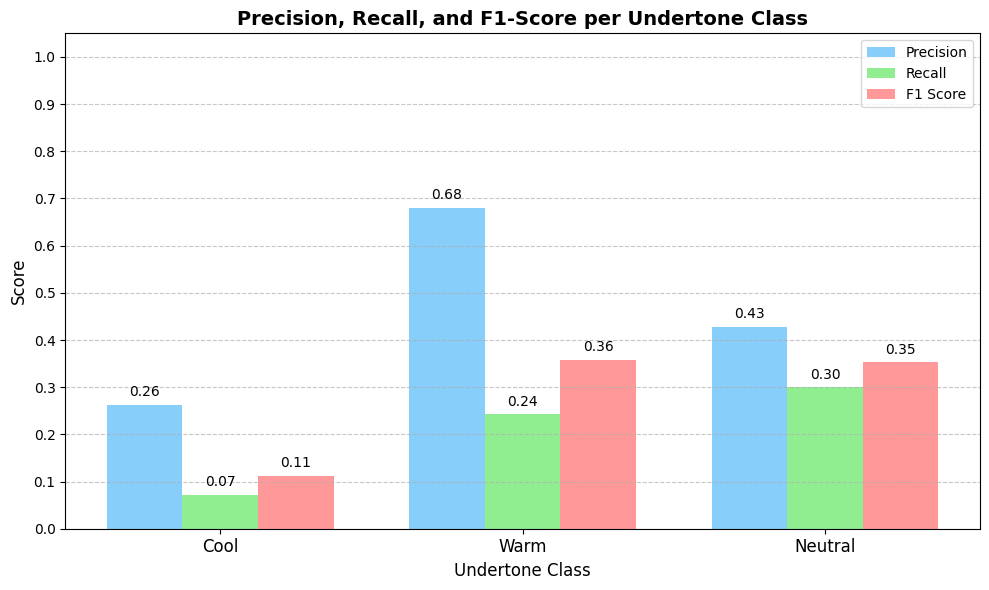


Overall Accuracy: 20.48%


In [372]:
precision, recall, f1, support = precision_recall_fscore_support(
    actuals, predictions, labels=labels, zero_division=0
)
accuracy = accuracy_score(actuals, predictions)

x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(10, 6))
bar1 = plt.bar(x - width, precision, width=width, label='Precision', color='#87CEFA')
bar2 = plt.bar(x, recall, width=width, label='Recall', color='#90EE90')
bar3 = plt.bar(x + width, f1, width=width, label='F1 Score', color='#FF9999')

# Annotate bars
for bars in [bar1, bar2, bar3]:
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f"{height:.2f}",
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 4),
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=10)

plt.xticks(x, [l.capitalize() for l in labels], fontsize=12)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylim(0, 1.05)
plt.ylabel("Score", fontsize=12)
plt.xlabel("Undertone Class", fontsize=12)
plt.title("Precision, Recall, and F1-Score per Undertone Class", fontsize=14, weight='bold')
plt.legend(loc="upper right")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nOverall Accuracy:", f"{accuracy * 100:.2f}%")

In [373]:
import pandas as pd
from IPython.display import display

# Create DataFrame
summary_df = pd.DataFrame(lab_points, columns=["a*", "b*", "True", "Predicted"])

# Round values
summary_df["a*"] = summary_df["a*"].round(2)
summary_df["b*"] = summary_df["b*"].round(2)

# Style: Yellow background + black font for mismatches
def highlight_mismatches(row):
    style = []
    mismatch = row["True"] != row["Predicted"]
    for _ in row:
        if mismatch:
            style.append("background-color: #fff3b0; color: black")
        else:
            style.append("")
    return style

# Show all rows
pd.set_option('display.max_rows', None)

# Display styled table
display(summary_df.style.apply(highlight_mismatches, axis=1))


,a*,b*,True,Predicted
0,16.300000,15.070000,cool,cool
1,13.450000,16.010000,cool,neutral
2,8.780000,13.810000,cool,unclassified
3,13.500000,14.550000,cool,unclassified
4,14.190000,13.930000,cool,unclassified
5,10.430000,23.420000,cool,warm
6,11.000000,22.790000,cool,warm
7,13.940000,16.280000,cool,neutral
8,13.140000,17.010000,cool,neutral
9,3.240000,3.810000,cool,unclassified


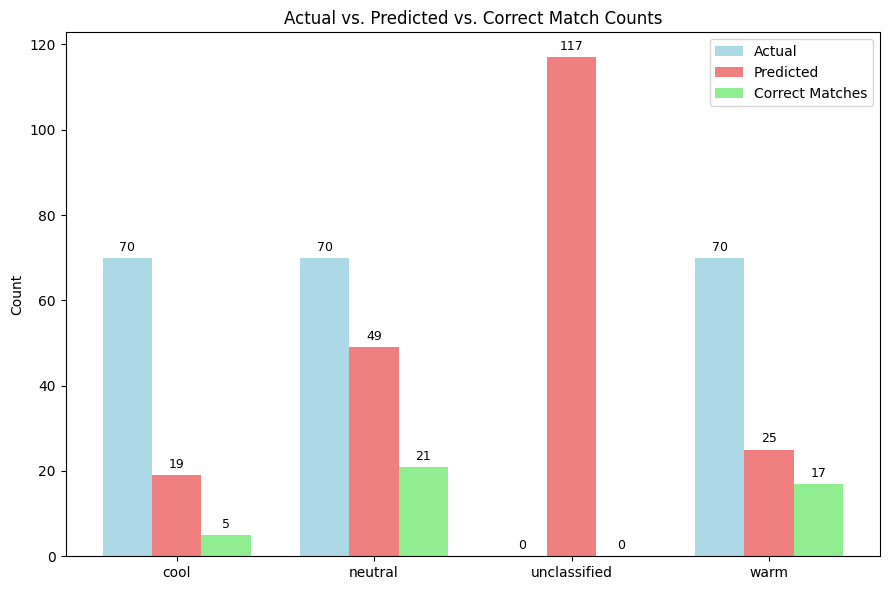


Accuracy per class:
Cool: 7.14%
Neutral: 30.00%
Unclassified: 0.00%
Warm: 24.29%


In [374]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Create DataFrames
df_actual = pd.DataFrame(actuals, columns=["Actual"])
df_pred = pd.DataFrame(predictions, columns=["Predicted"])

# Combine into one DataFrame to compare
df_compare = pd.concat([df_actual, df_pred], axis=1)

# Get unique labels
labels = sorted(set(actuals + predictions))

# Count Actuals, Predictions, and Matches
actual_counts = df_actual["Actual"].value_counts().reindex(labels, fill_value=0)
pred_counts = df_pred["Predicted"].value_counts().reindex(labels, fill_value=0)

# Count Correct Matches per class
match_counts = df_compare[df_compare["Actual"] == df_compare["Predicted"]]["Actual"].value_counts()
match_counts = match_counts.reindex(labels, fill_value=0)

# Plotting
x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(9, 6))

bar1 = ax.bar(x - width, actual_counts, width=width, label='Actual', color='lightblue')
bar2 = ax.bar(x, pred_counts, width=width, label='Predicted', color='lightcoral')
bar3 = ax.bar(x + width, match_counts, width=width, label='Correct Matches', color='lightgreen')

# Add counts on top
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{int(height)}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

add_labels(bar1)
add_labels(bar2)
add_labels(bar3)

# Customize
ax.set_title("Actual vs. Predicted vs. Correct Match Counts")
ax.set_ylabel("Count")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.tight_layout()
plt.show()

# Calculate per-class accuracy
accuracy_per_class = (match_counts / actual_counts).fillna(0)

# Print per-class accuracy
print("\nAccuracy per class:")
for label in labels:
    print(f"{label.capitalize()}: {accuracy_per_class[label]*100:.2f}%")


### Final Conclusion

This experiment evaluated whether existing skin tone detection techniques—specifically HSV-based skin masking combined with dominant color extraction using the ColorThief library—can accurately classify **skin undertones** based on CIELAB color values.

Using a rule-based classification schema derived from color theory and literature (Lagouvardos et al., 2018), undertones were categorized as **cool**, **warm**, or **neutral** based on the chromatic attributes `a*` and `b*`. The system’s predictions were evaluated against pre-labeled ground truth undertone data across a dataset of 120 facial images (40 per class).

---

#### Experimental Findings

- The system achieved an **overall accuracy of 20.48%** on the 210-image dataset.
- A significant number of predictions were either **incorrectly classified** or marked as **"unclassified"**, especially for borderline chromatic values or improperly masked skin regions.
- Several samples yielded CIELAB values like `a* = 0, b* = 0`, indicating that **HSV-based skin masking failed** on certain images—often due to lighting or background noise.

These results indicate that while a rule-based approach grounded in perceptual color theory can offer interpretability, it is **insufficiently robust** for real-world undertone detection. The model struggles with variations in lighting, subtle undertone cues, and complex skin tone patterns that can't be captured by a single dominant color.

---

#### Limitations of the Current System

- **HSV skin masking** is highly sensitive to lighting, often excluding valid skin pixels or introducing background noise.
- **ColorThief’s dominant color extraction** reduces the entire facial region to a single RGB value, ignoring crucial chromatic gradients and spatial distributions across the skin.
- **Rule-based thresholds**, while interpretable, fail in edge cases and do not adapt to inter-individual variation or nuanced undertones.
- Many outputs are **“unclassified,”** leaving ambiguity in result interpretation and limiting system reliability.

---

#### How Our Thesis Proposes to Address These Issues

The thesis system—**A Facial Image-Based CNN and CIELAB System for Skin Tone and Undertone Detection**—is built to address the limitations revealed by this experiment:

- It processes the **entire facial image**, capturing spatial and contextual chromatic features rather than relying on a single skin pixel.
- A **Convolutional Neural Network (CNN)** is trained to detect undertone features from image patterns learned across many examples, improving generalization.
- It integrates **CIELAB color space features** to retain interpretability and align with perceptual color differences.
- It uses **expert-labeled undertone data**, especially tuned for **Filipino skin tones**, and accounts for **real-world conditions** like lighting, shadows, and camera variations.

---

#### Conclusion

The low performance of the rule-based baseline model (20.48% accuracy) emphasizes the need for a more adaptive, data-driven solution to undertone detection. These results support the direction of the thesis—to use deep learning models that can interpret skin chromatic features holistically and more accurately. This is particularly critical for inclusive technologies in cosmetics, dermatology, and personal beauty applications.